# kaggle playground Spaceship titanic competition 프로젝트
### **진행기간** :  2023-11-01~2023-11-31  
### **사용한 라이브러리** : Tensorflow, tfdf, keras,  scikit-learn, pandas
### **성과** : 정확도 80% 달성
### **프로젝트 리뷰**  
he normal 초기화의 역할, 사용법을 학습했다.  
피드포워드 네트워크로 의사결정트리 알고리즘을 흉내냈다.  
몇십개의 노드부터 수천만개의 노드까지, 한개의 층부터 수십개의 층까지 모두 구현해보고 사용해보았다. (진짜 재미있었다.)  
과적합을 해결하기 위해 활성함수도 다양하게 사용해보고 위의 과정도 해보고 dropout 조정, batch size 조정 등을 진행했다.  
정확도 80%를 달성하고 다른 참가자의 notebook을 보며 tfdf randomforest의 존재와 XGBoost의 존재를 알게 되었다.  
이런 분류, 회귀문제의 경우 이미 잘 구현된 모델들이 많다는것도 알게되었다.  
학습률 파라미터를 조정해보지 못했는데 이 부분이 많이 아쉽다.



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import os
import matplotlib
import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import RobustScaler
import datetime
from tensorflow.keras.callbacks import EarlyStopping

2023-11-29 13:01:41.722438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:01:41.722482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:01:41.724340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 13:01:41.863221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 13:01:42.916787: W tensorflow/compiler/

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [3]:
scl = MinMaxScaler()
scl_rb = RobustScaler()
initializer1 = tf.keras.initializers.HeNormal(seed=None)
bn_mtc = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)
bn_cross_entrp = tf.keras.metrics.BinaryCrossentropy(
    name='binary_crossentropy',
    dtype=None,
    from_logits=False,
    label_smoothing=0
)
save_best_callback = ModelCheckpoint(
    'best_arin.h5',  
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


2023-11-29 13:01:46.427842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 13:01:46.581497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 13:01:46.581550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 13:01:46.583434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 13:01:46.583483: I tensorflow/compile

전처리 과정이다. 
numeric 하지 않은 변수들을 당시에 어떻게 처리해야 할 지 몰라서 drop하고 진행했다.
Destination 변수는 하드코딩으로 ordinal 인코딩을 진행했는데,  
원 핫 인코딩을 인코더 사용하여 진행했으면 하는 아쉬움이 남는다.
결측치 또한 마찬가지이다.  
결측치는 룸서비스에 관련된 부분들, 시설 사용 관련 부분들은 0으로 처리했다. 왜냐하면 이 부분이 결측치라는건 사용하지 않았다는 뜻이고, 비용이 발생할 수 없다고 생각했기 때문이다.  
여러가지 변수들을 조합해서 데이터프레임을 만든 이유는 앙상블 모델의 입력으로 사용하기 위해서 상관관계가 있다고 판단한 변수들끼리 모아 진행했다.


In [4]:
df_train = train.drop(["Name", "PassengerId", "Cabin"], axis= 1)

df_train["RoomService"].fillna(0, inplace=True)
df_train["FoodCourt"].fillna(0, inplace=True)
df_train["ShoppingMall"].fillna(0, inplace=True)
df_train["Spa"].fillna(0, inplace=True)
df_train["VRDeck"].fillna(0, inplace=True)
df_train["HomePlanet"].fillna("Earth", inplace=True)
df_train["Destination"].fillna("TRAPPIST-1e", inplace=True)
df_train["CryoSleep"].fillna(0, inplace=True)
df_train["VIP"].fillna(0, inplace=True)
df_train["Age"].fillna(29, inplace=True)
df_train.loc[df_train["Destination"]=="TRAPPIST-1e", "Destination"]=0
df_train.loc[df_train["Destination"]=="55 Cancri e", "Destination"]=1
df_train.loc[(df_train["Destination"] != "55 Cancri e") & (df_train["Destination"] != "TRAPPIST-1e"),"Destination"]=2
df_train.loc[df_train["HomePlanet"]=="Earth", "HomePlanet"]=0
df_train.loc[df_train["HomePlanet"]=="Europa", "HomePlanet"]=1
df_train.loc[df_train["HomePlanet"]=="Mars", "HomePlanet"]=2

df_test = test.drop([ "Name", "PassengerId", "Cabin"], axis= 1)
df_test["RoomService"].fillna(0, inplace=True)
df_test["FoodCourt"].fillna(0, inplace=True)
df_test["ShoppingMall"].fillna(0, inplace=True)
df_test["Spa"].fillna(0, inplace=True)
df_test["VRDeck"].fillna(0, inplace=True)
df_test["HomePlanet"].fillna("Earth", inplace=True)
df_test["Destination"].fillna("TRAPPIST-1e", inplace=True)
df_test["CryoSleep"].fillna(0, inplace=True)
df_test["VIP"].fillna(0, inplace=True)
df_test["Age"].fillna(29, inplace=True)
df_test.loc[df_test["Destination"]=="TRAPPIST-1e", "Destination"]=0
df_test.loc[df_test["Destination"]=="55 Cancri e", "Destination"]=1
df_test.loc[(df_test["Destination"] != "55 Cancri e") & (df_test["Destination"] != "TRAPPIST-1e"),"Destination"]=2
df_test.loc[df_test["HomePlanet"]=="Earth", "HomePlanet"]=0
df_test.loc[df_test["HomePlanet"]=="Europa", "HomePlanet"]=1
df_test.loc[df_test["HomePlanet"]=="Mars", "HomePlanet"]=2

df_test = df_test.astype(int)
df_train = df_train.astype(int)

df_train_to = df_train.loc[:,["HomePlanet", "Destination","CryoSleep", "Transported"]]
df_train_to = df_train_to.astype(float)

df_train_tp = df_train_to["Transported"]
df_train_to = df_train_to.drop(["Transported"], axis=1)

df_train_to_rs = df_train.loc[:,["HomePlanet", "Destination","CryoSleep", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]]

df_train_to_rs_tp = df_train_to_rs["Transported"]
df_train_to_rs = df_train_to_rs.drop(["Transported"], axis=1)

df_train_rs = df_train_to_rs.loc[:,["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]]

df_train_tp = df_train["Transported"]

df_train_a_v = df_train.loc[:,["Age", "VIP"]]
df_train_a_v = df_train_a_v.astype(int)

df_test_to = df_test.loc[:,["HomePlanet", "Destination","CryoSleep"]]
sl_test_rs = scl_rb.fit_transform(df_test[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])
df_sltest_rs = pd.DataFrame(sl_test_rs, index=df_test.index, columns=["sl_RS", "sl_FC", "sl_SM", "sl_SPA", "sl_VR"])
df_test_a_v = df_test.loc[:,["Age", "VIP"]]

sl_rs = scl_rb.fit_transform(df_train_rs[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])
df_sl_rs = pd.DataFrame(sl_rs, index=df_train_rs.index, columns=["sl_RS", "sl_FC", "sl_SM", "sl_SPA", "sl_VR"])

df_train_vp_rs = pd.concat([df_train_a_v, df_sl_rs, df_train_to["CryoSleep"]], axis=1)
df_test_vp_rs = pd.concat([df_test_a_v, df_sltest_rs, df_test["CryoSleep"]], axis=1)

In [120]:
df_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39,0,0,0,0,0,0,0
1,0,0,2,24,0,109,9,25,549,44,1
2,1,0,2,58,1,43,3576,0,6715,49,0
3,1,0,2,33,0,0,1283,371,3329,193,0
4,0,0,2,16,0,303,70,151,565,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,2,41,1,0,6819,0,1643,74,0
8689,0,1,2,18,0,0,0,0,0,0,0
8690,0,0,2,26,0,0,0,1872,1,0,1
8691,1,0,2,32,0,0,1049,0,353,3235,0


In [5]:
df_s_train_to, df_ev_to = train_test_split(df_train_to, test_size=0.2, random_state=20)
df_s_train_rs, df_ev_rs = train_test_split(df_sl_rs, test_size=0.2, random_state=20)
df_s_train_a_v, df_ev_a_v = train_test_split(df_train_a_v, test_size=0.2, random_state=20)
df_s_train_tp, df_s_ev_tp = train_test_split(df_train_tp, test_size=0.2, random_state=20)
df_s_train_vp_rs, df_s_ev_vp_rs = train_test_split(df_train_vp_rs, test_size=0.2, random_state=20)
df_tfdf_train, df_tfdf_ev = train_test_split(df_train, test_size=0.2, random_state=20)

과적합 문제와 학습이 진행되지 않는 문제때문에 입력을 여러개로, 각자 다르게 해서 진행해보았다.  
이 파일, 셀에서 수정을 반복했기에 여러가지 형태는 이미지로만 남아있다... 모델 버전관리도 중요하다는것을 깨달았다.

In [112]:
def arin_4_elu():
    nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
    input_to = Input(shape=(3,)) 
    x = Dense(256, activation = 'elu', kernel_initializer=initializer1)(input_to)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    input_rs = Input(shape=(5,))
    y = Dense(512, activation = 'elu', kernel_initializer=initializer1)(input_rs)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)
 
    input_a_v = Input(shape = (2,))
    z = Dense(32, activation = 'elu', kernel_initializer=initializer1)(input_a_v)
    z = BatchNormalization()(z)
    z = Dropout(0.55)(z)
    
    input_cry = Input(shape=(8,))
    i = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(input_cry)
    i = BatchNormalization()(i) 
    i = Dropout(0.2)(i)
    
    sum_xyz = layers.Concatenate()([y, x, z, i])
    s = BatchNormalization()(sum_xyz)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)

    output = layers.Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal')(s)

    arin4_elu = Model(inputs = [input_to, input_rs, input_a_v, input_cry], outputs = output, name = "ARIN4_elu")
    arin4_elu.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
    arin4_elu.summary()
    
    return arin4_elu

In [113]:
def arin_3_elu():
    nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
    
    
    input_to = Input(shape=(3,)) 
    x = Dense(256, activation = 'elu', kernel_initializer=initializer1)(input_to)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    input_rs = Input(shape=(5,))
    y = Dense(512, activation = 'elu', kernel_initializer=initializer1)(input_rs)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)
    
    input_cry = Input(shape=(8,))
    i = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(input_cry)
    i = BatchNormalization()(i)
    i = Dropout(0.2)(i)
   
    sum_xyz = layers.Concatenate()([x, y, i])
    s = BatchNormalization()(sum_xyz)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(sum_xyz)
    s = Dropout(0.5)(s)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    
    output = layers.Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal')(s)

    arin3_elu = Model(inputs = [input_to, input_rs, input_cry], outputs = output, name = "ARIN3_elu")
    arin3_elu.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
    arin3_elu.summary()
    
    return arin3_elu

In [114]:
def arin_3_age_elu():
    nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
    
    
    input_to = Input(shape=(3,)) 
    x = Dense(256, activation = 'elu', kernel_initializer=initializer1)(input_to)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    input_a_v = Input(shape=(2,))
    y = Dense(32, activation = 'elu', kernel_initializer=initializer1)(input_a_v)
    y = BatchNormalization()(y)
    y = Dropout(0.55)(y)
    
    input_rs = Input(shape=(5,))
    i = Dense(512, activation = 'elu', kernel_initializer=initializer1)(input_rs) 
    i = BatchNormalization()(i)
    i = Dropout(0.2)(i)
    
    sum_xyz = layers.Concatenate()([x, y, i])
    s = BatchNormalization()(sum_xyz)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(sum_xyz)
    s = Dropout(0.4)(s)
    s = Dense(1024, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.4)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    
    output = layers.Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal')(s)

    arin3_elu = Model(inputs = [input_to, input_a_v, input_rs], outputs = output, name = "ARIN3_elu")
    arin3_elu.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
    arin3_elu.summary()
    
    return arin3_elu

In [115]:
def arin_2_elu():
    nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
        
    input_to = Input(shape=(3,)) 
    x = Dense(256, activation = 'elu', kernel_initializer=initializer1)(input_to)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    input_rs = Input(shape=(5,))
    y = Dense(512, activation = 'elu', kernel_initializer=initializer1)(input_rs)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)
    
    sum_xyz = layers.Concatenate()([x, y])
    s = BatchNormalization()(sum_xyz)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(sum_xyz)
    s = Dropout(0.5)(s)
    s = Dense(512, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(256, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)
    s = Dense(256, activation = 'elu', kernel_initializer=initializer1)(s)
    s = Dropout(0.5)(s)

    
    output = layers.Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal')(s)

    arin2_elu = Model(inputs = [input_to, input_rs], outputs = output, name = "ARIN2_elu")
    arin2_elu.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
    arin2_elu.summary()
    
    return arin2_elu

위의 모델들의 출력을 합쳐서 학습시켜보려고 했는데 진행도 잘 되지 않았고 결과또한 이상하게 나와서 거의 사용하지 않았다.

In [67]:
def arin_esb():
    #nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
    model1_input = Input(shape=(1,))
    model2_input = Input(shape=(1,))
    model3_input = Input(shape=(1,))
    model4_input = Input(shape=(1,))
    con_arin = concatenate([model1_input, model2_input, model3_input, model4_input])
    esb_out = Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal')(con_arin)
    
    arin_esb = Model(inputs=[model1_input, model2_input, model3_input, model4_input], outputs = esb_out, name = "Arin_esb")
    arin_esb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return arin_esb

In [ ]:
arin_4_elu = arin_4_elu()
arin4_his = arin_4_elu.fit([df_s_train_to, df_s_train_rs, df_s_train_a_v, df_s_train_vp_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs, df_ev_a_v, df_s_ev_vp_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])
test_eval_elu = arin_4_elu.evaluate([df_ev_to, df_ev_rs, df_ev_a_v, df_s_ev_vp_rs], df_s_ev_tp, verbose=2)


In [ ]:
arin_3_elu = arin_3_elu()
arin3_his = arin_3_elu.fit([df_s_train_to, df_s_train_rs, df_s_train_vp_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs,  df_s_ev_vp_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])
test_eval_elu = arin_3_elu.evaluate([df_ev_to, df_ev_rs, df_s_ev_vp_rs], df_s_ev_tp, verbose=2)

In [ ]:
arin_2_elu = arin_2_elu()
arin2_his = arin_2_elu.fit([df_s_train_to, df_s_train_rs, df_s_train_vp_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs,  df_s_ev_vp_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])
test_eval_elu = arin_2_elu.evaluate([df_ev_to, df_ev_rs, df_s_ev_vp_rs], df_s_ev_tp, verbose=2)

In [116]:
arin_4_elu = arin_4_elu()
arin4_his = arin_4_elu.fit([df_s_train_to, df_s_train_rs, df_s_train_a_v, df_s_train_vp_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs, df_ev_a_v, df_s_ev_vp_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])

arin_3_elu = arin_3_elu()
arin3_his = arin_3_elu.fit([df_s_train_to, df_s_train_rs, df_s_train_vp_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs,  df_s_ev_vp_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])

arin_3_age_elu = arin_3_age_elu()
arin3_age_his = arin_3_age_elu.fit([df_s_train_to, df_s_train_a_v, df_s_train_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_a_v, df_ev_rs,], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])

arin_2_elu = arin_2_elu()
arin2_his = arin_2_elu.fit([df_s_train_to, df_s_train_rs], df_s_train_tp, epochs = 100, batch_size = 32, verbose=2, validation_data=([df_ev_to, df_ev_rs], df_s_ev_tp), callbacks=[tensorboard_callback, early_stopping])

test_eval_4_elu = arin_4_elu.evaluate([df_ev_to, df_ev_rs, df_ev_a_v, df_s_ev_vp_rs], df_s_ev_tp, verbose=2)
test_eval_3_elu = arin_3_elu.evaluate([df_ev_to, df_ev_rs, df_s_ev_vp_rs], df_s_ev_tp, verbose=2)
test_eval_3_age_elu = arin_3_age_elu.evaluate([df_ev_to, df_ev_a_v, df_ev_rs,], df_s_ev_tp, verbose=2)
test_eval_2_elu = arin_2_elu.evaluate([df_ev_to, df_ev_rs], df_s_ev_tp, verbose=2)

Model: "ARIN4_elu"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_158 (InputLayer)      [(None, 5)]                  0         []                            
                                                                                                  
 input_157 (InputLayer)      [(None, 3)]                  0         []                            
                                                                                                  
 input_159 (InputLayer)      [(None, 2)]                  0         []                            
                                                                                                  
 input_160 (InputLayer)      [(None, 8)]                  0         []                            
                                                                                          

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


 dropout_297 (Dropout)       (None, 512)                  0         ['batch_normalization_185[0][0
                                                                    ]']                           
                                                                                                  
 dropout_296 (Dropout)       (None, 256)                  0         ['batch_normalization_184[0][0
                                                                    ]']                           
                                                                                                  
 dropout_298 (Dropout)       (None, 32)                   0         ['batch_normalization_186[0][0
                                                                    ]']                           
                                                                                                  
 dropout_299 (Dropout)       (None, 1024)                 0         ['batch_normalization_187[0][0
          

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
218/218 - 9s - loss: 2.4536 - accuracy: 0.6805 - val_loss: 0.7567 - val_accuracy: 0.7395 - 9s/epoch - 40ms/step
Epoch 2/100
218/218 - 5s - loss: 1.1007 - accuracy: 0.6997 - val_loss: 0.4858 - val_accuracy: 0.7815 - 5s/epoch - 24ms/step
Epoch 3/100
218/218 - 5s - loss: 0.6653 - accuracy: 0.7206 - val_loss: 0.4675 - val_accuracy: 0.7901 - 5s/epoch - 24ms/step
Epoch 4/100
218/218 - 5s - loss: 0.5577 - accuracy: 0.7380 - val_loss: 0.4922 - val_accuracy: 0.7878 - 5s/epoch - 23ms/step
Epoch 5/100
218/218 - 5s - loss: 0.5272 - accuracy: 0.7525 - val_loss: 0.4833 - val_accuracy: 0.7694 - 5s/epoch - 23ms/step
Epoch 6/100
218/218 - 5s - loss: 0.5120 - accuracy: 0.7616 - val_loss: 0.4784 - val_accuracy: 0.7786 - 5s/epoch - 23ms/step
Epoch 7/100
218/218 - 5s - loss: 0.5016 - accuracy: 0.7561 - val_loss: 0.4573 - val_accuracy: 0.7838 - 5s/epoch - 23ms/step
Epoch 8/100
218/218 - 5s - loss: 0.4960 - accuracy: 0.7607 - val_loss: 0.4509 - val_accuracy: 0.7947 - 5s/epoch - 23ms/step
Epoch 9/

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
218/218 - 8s - loss: 1.5902 - accuracy: 0.6937 - val_loss: 0.4999 - val_accuracy: 0.7746 - 8s/epoch - 39ms/step
Epoch 2/100
218/218 - 5s - loss: 0.7612 - accuracy: 0.7125 - val_loss: 0.4681 - val_accuracy: 0.7803 - 5s/epoch - 23ms/step
Epoch 3/100
218/218 - 5s - loss: 0.5645 - accuracy: 0.7446 - val_loss: 0.4993 - val_accuracy: 0.6993 - 5s/epoch - 22ms/step
Epoch 4/100
218/218 - 5s - loss: 0.5277 - accuracy: 0.7430 - val_loss: 0.4508 - val_accuracy: 0.7918 - 5s/epoch - 22ms/step
Epoch 5/100
218/218 - 5s - loss: 0.5028 - accuracy: 0.7617 - val_loss: 0.4486 - val_accuracy: 0.7878 - 5s/epoch - 22ms/step
Epoch 6/100
218/218 - 5s - loss: 0.4903 - accuracy: 0.7668 - val_loss: 0.4520 - val_accuracy: 0.7861 - 5s/epoch - 22ms/step
Epoch 7/100
218/218 - 5s - loss: 0.4848 - accuracy: 0.7665 - val_loss: 0.4733 - val_accuracy: 0.7021 - 5s/epoch - 23ms/step
Epoch 8/100
218/218 - 5s - loss: 0.4863 - accuracy: 0.7675 - val_loss: 0.4617 - val_accuracy: 0.7844 - 5s/epoch - 23ms/step
Epoch 9/

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


218/218 - 7s - loss: 1.4210 - accuracy: 0.6767 - val_loss: 0.5202 - val_accuracy: 0.7849 - 7s/epoch - 31ms/step
Epoch 2/100
218/218 - 4s - loss: 0.8004 - accuracy: 0.6911 - val_loss: 0.4492 - val_accuracy: 0.7913 - 4s/epoch - 19ms/step
Epoch 3/100
218/218 - 4s - loss: 0.5789 - accuracy: 0.7377 - val_loss: 0.4654 - val_accuracy: 0.7688 - 4s/epoch - 19ms/step
Epoch 4/100
218/218 - 4s - loss: 0.5323 - accuracy: 0.7435 - val_loss: 0.4527 - val_accuracy: 0.7803 - 4s/epoch - 18ms/step
Epoch 5/100
218/218 - 4s - loss: 0.5133 - accuracy: 0.7542 - val_loss: 0.4563 - val_accuracy: 0.7769 - 4s/epoch - 18ms/step
Epoch 6/100
218/218 - 4s - loss: 0.4881 - accuracy: 0.7686 - val_loss: 0.4456 - val_accuracy: 0.7884 - 4s/epoch - 18ms/step
Epoch 7/100
218/218 - 4s - loss: 0.4845 - accuracy: 0.7603 - val_loss: 0.4512 - val_accuracy: 0.7832 - 4s/epoch - 18ms/step
Epoch 8/100
218/218 - 4s - loss: 0.4834 - accuracy: 0.7695 - val_loss: 0.4558 - val_accuracy: 0.7838 - 4s/epoch - 18ms/step
Epoch 9/100
218/218 

In [109]:
arin4_pred = arin_4_elu.predict([df_test_to, df_sltest_rs,df_test_a_v, df_test_vp_rs])
arin3_pred = arin_3_elu.predict([df_test_to, df_sltest_rs, df_test_vp_rs])
arin3_age_pred = arin_3_age_elu.predict([df_test_to, df_test_a_v, df_sltest_rs])
arin2_pred = arin_2_elu.predict([df_test_to, df_sltest_rs])

134/134 [==============================] - 1s 4ms/step


In [51]:
esb_train_4 = ([df_s_train_to, df_s_train_rs, df_s_train_a_v, df_s_train_vp_rs], df_s_train_tp)
esb_train_3 = ([df_s_train_to, df_s_train_rs, df_s_train_a_v], df_s_train_tp)

In [110]:
ensemble_pred = np.mean([arin4_pred, arin3_pred,arin3_age_pred, arin2_pred], axis=0)


In [ ]:
keras.utils.plot_model(arin_esb, "arin_esb_info.png", show_shapes=True)

<Axes: >

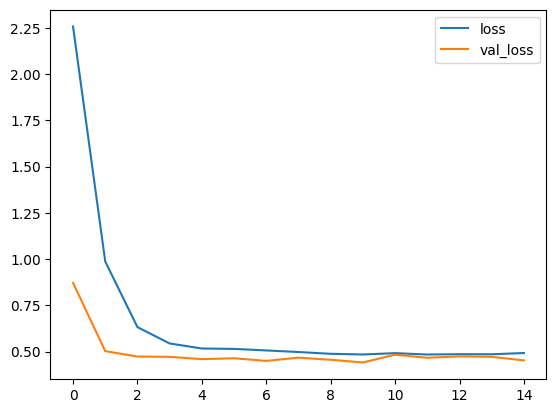

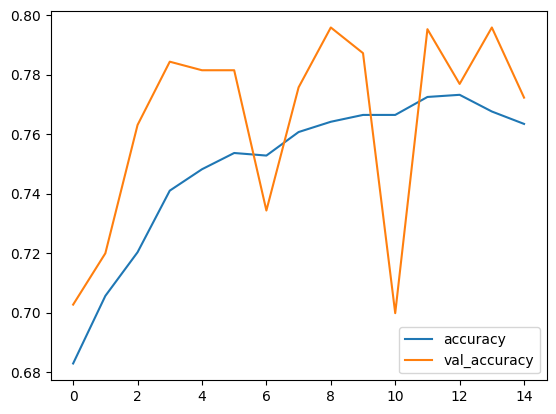

In [119]:
df_his = pd.DataFrame(arin4_his.history)
df_his[["loss",  "val_loss"]].plot()
df_his[["accuracy", "val_accuracy"]].plot()

In [111]:
bool_pred = (ensemble_pred > 0.5).astype(bool)
sub["Transported"] = bool_pred
sub.to_csv("submission_4_model_ensemble_elu.csv", index=False)

In [58]:
sub

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False
